# Chapter3. 평가

머신러닝은 데이터 가공/변환, 모델 학습/예측, 평가의 프로세스로 구성됨.

머신러닝 모델의 성능평가 지표는 일반적으로 모델이 분류나 회귀냐에 따라 여러종류로 나뉨.

 - 회귀의 경우 대부분 실제값과 예측값의 오차 평균값에 기반함. 
 - 분류의 평가방법도 일반적으로는 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반하지만, 단순히 이러한 정확도만 가지고 판단해서는 잘못될 수 있음.
 
 이진 분류의 성능 평가 지표에 대해서 집중적으로 설명.

----------------------------------------------------------------
<분류의 성능 평가 지표>

: 정확도, 오차행렬, 정밀도, 재현율, F1 스코어, ROC AUC...

: 분류는 결정 클래스 값 종류의 유형에 따라 긍정/부정과 같은 2개의 결괏값만을 가지는 이진 분류와 여러개의 결정 클래스 값을 가지는 멀티 분류로 나뉠 수 있음.


## [01] 정확도(Accuracy) 

 : 실제데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표.
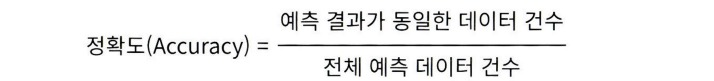

 - 이진 분류의 경우 데이터의 구성에 따라 ML모델의 성능을 왜곡할 수 있기 때문에 정확도 수치 하나만 가지고 성능을 평가하지 않음.

  정확도 지표가 어떻게 ML 모델의 성능을 왜곡하는지?
  
  다음 예제에서 사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고 성별에 따라 생성자를 예측하는 단순한 Classifier을 생성

In [5]:
#BaseEstimator를 상속받으면 Customized 형태의 Estimator를 개발자가 생성할 수 있음.
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    #fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X,y=None):
        pass
    #predict()메서드는 단순히 Sex 피처가 0, 그렇지 않으면 1로 예측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i]=0
            else:
                pred[i]=1
        return pred

   생성된 MyDummyClassifier을 이용해 타이타닉 생존자 예측을 수행.

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

#이전에 한 데이터 전처리 과정

# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace=True)
  df['Cabin'].fillna('N', inplace=True)
  df['Embarked'].fillna('N', inplace=True)
  df['Fare'].fillna(0, inplace=True)
  return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
  df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
  return df

# 레이블 인코딩 수행
from sklearn.preprocessing import LabelEncoder
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

#전처리 함수 가져오기 위한 코드
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('C:/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                    test_size=0.2, random_state=0)

#위에서 생성한 Dummy Classifier를 이용해 학습/ 예측/ 평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train ,y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifie의 정확도는 : {0:.4f}'.format(accuracy_score(y_test,mypredictions)))

Dummy Classifie의 정확도는 : 0.7877


**=> 정확도는 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님.**

 - MNIST 데이터 세트를 변환해 불균형한 데이터 세트로 만든 뒤에 정확도 지표 적용 시 어떤 문제가 발생할 수 있는지 살펴봄.
 
 : MNIST 데이터 세트는 0부터 9까지 의 숫자 이미지의 픽셀 정보를 가지고 있으며, 이를 기반으로 숫자 Digit를 예측하는 데 사용함. 
 
 >레이블이 7인것만 True, 나머지 값은 모두 False로 변환해 이진분류 문제로 바꿈. 

In [13]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self,X,y):
        pass
    #입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

#사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

#digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target ==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data,y,random_state=11)

In [15]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스터 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train,y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test,fakepred)))

레이블 테스터 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


이처럼 정확도 평가 지표는 불균형한 레이블 데이터 세트에서는 성능수치로 사용돼서는 안됨.

## [02] 오차 행렬 

 : 이진 분류에서 성능 지표로 잘 활용됨. 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타냄.

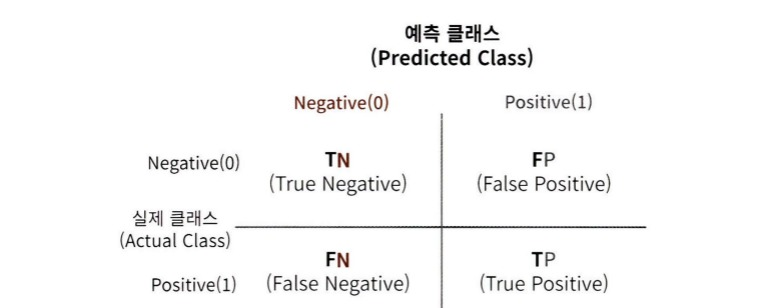

TN,FP, FN, TP 형태로 오차행렬의 4분면을 채움. 예측값과 실제값이 같은지, 예측 결과값이 부정인지 긍정인지를 의미.

 - 오차행렬을 구하기 위해 confusion_matrix() API를 제공함. 

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

 - TP, TN, FP, TN 값은 Classdifier 성능을 판단.(정확도, 정밀도, 재현율)
 - 정확도는 예측값과 실제 갑싱 얼마난 동일한가에 대한 비율만으로 결정.
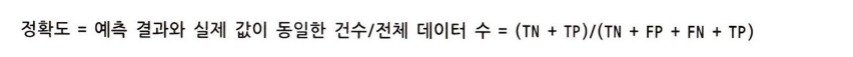

 - 불균형한 이진 분류 데이터 세트에서는 positive 데이터 건수가 매우 작기 때문에 데이터에 기반한 ML 알고리즘은 Negative로 예측 정확도가 높아지는 경향. -> 불균형 데이터 세트에서 정확도만으로는 모델 신뢰도가 떨어짐.

## [3] 정밀도와 재현율 

: 정밀도와 재현율은 positive데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표.
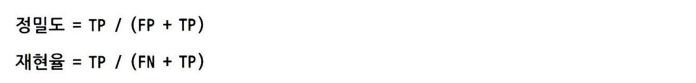

 - 정밀도는 예측을 positiv로 한 대상 중에 예측과 실제 값이 positive로 일치한 데이터의 비율.양성 예측도라고도 함. 
 - 재현율은 실제 값이 positiv인 대상중에 예측과 실제 값이 positive로 일치한 데이터의 비율. 민감도 또는 TPR이라고도 함. 

정밀도와 재현율 지표 중에 이진 분류 모델의 업무 특성에 따라 특정 평가 지표가 더 중요한 지표로 간주 될 수 있음. 

: 재현율이 중요지표인 경우는 실제 positive양성 데이터를 negative로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우.
: 정밀도가 중요지표인 경우는 실제 negative음성인 데이터 예측을 양성으로 잘못 판단하게 되면 업무상 큰 영향이 발생하는 경우.

-> 가장 좋은 성능 평가는 재현울과 정밀도 모두 높은 수치를 얻는 것. 

 - 사이킷런은 정밀도 계산을 위해 precision_score()를 , 재현율 계산을 위해 recall_score()를 제공.

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도:{0:.4f},정밀도:{1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [22]:
#로지스틱 회귀 기반으로 타이타닉 생존자 예측하기

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테슽트 데이터 분할
titanic_df = pd.read_csv('C:/data/titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived',axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train,X_test,y_train,y_test = train_test_split(X_titanic_df,y_titanic_df,test_size = 0.2, random_state = 11)
lr_clf = LogisticRegression()

lr_clf.fit(X_train,y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test,pred)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742, 재현율:0.7869


C:\Users\june0\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**[정밀도/재현율 트레이드오프]**

 - 개별 예측 확률을 반환한다 : predict_proba()
 - 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능하다
 - ndarray(mxn) 형태로 반환한다 -> m : 입력 데이트 레코드의 수, n: 클래스 값 유형 
 - 각 열은 개별 클래스의 예측 확률. 첫번째: 0(Negative) , 두번째: 1(Positive)

In [23]:
#predict_proba()와 predict() 결과 비교해보기
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba() 결과 Shape: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n :', pred_proba[:3])

#예측확률 array와 예측 결괏값 array를 병합(concatente)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba,pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba() 결과 Shape: (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
 : [[0.46155514 0.53844486]
 [0.8786588  0.1213412 ]
 [0.87725934 0.12274066]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.46155514 0.53844486 1.        ]
 [0.8786588  0.1213412  0.        ]
 [0.87725934 0.12274066 0.        ]]


In [24]:
from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

#X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


get_clf_eval()함수를 적용해 평가 지표도 출력.

In [26]:
from sklearn.preprocessing import Binarizer

#Binarizer의 threshold 설정값, 분류 결정 임곗값임.
custom_threshold = 0.5

#predict_proba()반환값의 두번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742, 재현율:0.7869


이 분류 결정의 임곗값을 낮추면

In [27]:
custom_threshold = 0.4
pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test,custom_predict)       #재현율이 올라가고 정밀도가 떨어졌다

오차 행렬
[[99 19]
 [10 51]]
정확도:0.8380,정밀도:0.7286, 재현율:0.8361


임곗값을 0.4에서 0.6까지 0.05씩 증가시키며 평가 지표를 조사.

In [28]:
#테스트를 수행할 모든 임겠값 리스트 객체로 저장.
thresholds = [0.4,0.45,0.50,0.55,0.60]

def get_eval_by_threshold(y_test,pred_proba_c1,threshold):
  #thresholds list객체 내의 값을 차례로 iteration하면서 Evlauation 수행.
  for custom_threshold in thresholds:
    binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
    custom_predict = binarizer.transform(pred_proba_c1)
    print('임곗값:',custom_threshold)
    get_clf_eval(y_test,custom_predict)

get_eval_by_threshold(y_test,pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도:0.8380,정밀도:0.7286, 재현율:0.8361
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도:0.8492,정밀도:0.7656, 재현율:0.8033
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도:0.8492,정밀도:0.7742, 재현율:0.7869
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도:0.8659,정밀도:0.8364, 재현율:0.7541
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도:0.8771,정밀도:0.8824, 재현율:0.7377


precision_recall_curve()를 이용해 타이타닉 예측 모델의 임곗값별 정밀도와 재현율을 구함. 

In [29]:
from sklearn.metrics import precision_recall_curve

#레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

#반환된 임계값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 Step으로 추출
thr_index = np.arange(0,thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index],3))
     

반환된 분류 결정 임곗값 배열의 Shape: (143,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값: [0.1  0.12 0.14 0.19 0.28 0.4  0.56 0.67 0.82 0.95]
샘플 임계값별 정밀도: [0.389 0.44  0.466 0.539 0.647 0.729 0.836 0.949 0.958 1.   ]
샘플 임계값별 재현율: [1.    0.967 0.902 0.902 0.902 0.836 0.754 0.607 0.377 0.148]


 정밀도와 재현율 곡선을 시각화


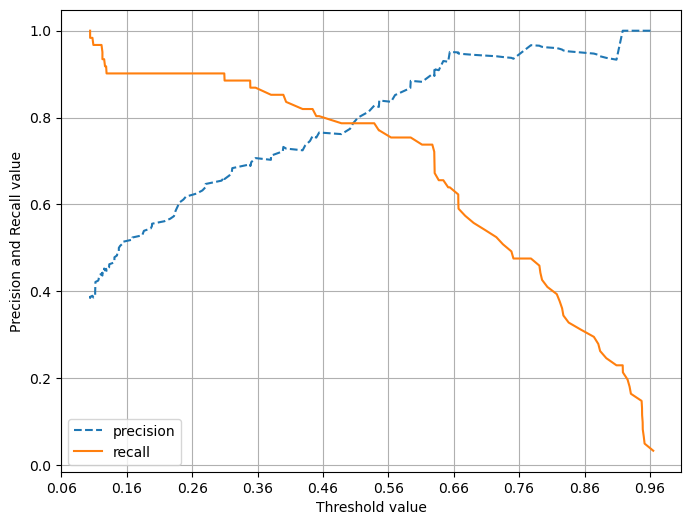

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds,precisions[0:threshold_boundary], linestyle='--',label='precision')
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recall')

    #threshold 값 x 축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))

    #x축,y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend();plt.grid()
    plt.show()

precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

**[정밀도와 재현율의 맹점]**

 - 정밀도가 100%가 되는 방법 : 확실한 기준이 되는 경우만 positive로 예측하고 나머지는 모두 negative로 예측.
 - 재현율이 100%가 되는 방법: 모든 환자를 positive로 예측하면 됨. 

## [04] F1 스코어 

: F1 스코어는 정밀도와 재현율을 결합한 지표.

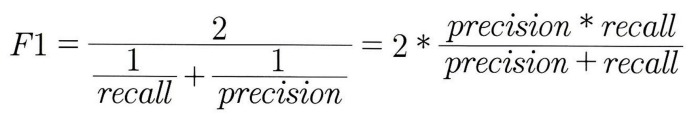

 - f1_score()라는 API 제공.

In [33]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어: {0:.4f}'.format(f1))

F1 스코어: 0.7805


 - 임곗값을 변화시키면서 F1스코어를 포함한 평가지표를 구함.

In [34]:
#타이타닉 생존자 예측에서 F1 스코어를 포함한 평가 지표
def get_clf_eval(y_test,pred):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  #F1 스코어 추가
  f1 = f1_score(y_test,pred)
  print('오차 행렬')
  print(confusion)
  #f1 score print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f}, F1: {3:.4f}'.format(accuracy, precision,recall,f1))

thresholds = [0.4,0.45,0.50,0.55,0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1),thresholds)

임곗값: 0.4
오차 행렬
[[99 19]
 [10 51]]
정확도: 0.8380, 정밀도: 0.7286, 재현율 : 0.8361, F1: 0.7786
임곗값: 0.45
오차 행렬
[[103  15]
 [ 12  49]]
정확도: 0.8492, 정밀도: 0.7656, 재현율 : 0.8033, F1: 0.7840
임곗값: 0.5
오차 행렬
[[104  14]
 [ 13  48]]
정확도: 0.8492, 정밀도: 0.7742, 재현율 : 0.7869, F1: 0.7805
임곗값: 0.55
오차 행렬
[[109   9]
 [ 15  46]]
정확도: 0.8659, 정밀도: 0.8364, 재현율 : 0.7541, F1: 0.7931
임곗값: 0.6
오차 행렬
[[112   6]
 [ 16  45]]
정확도: 0.8771, 정밀도: 0.8824, 재현율 : 0.7377, F1: 0.8036


## [05] ROC 곡선과 AUC 

: ROC곡선은 수신자 판단 곡선. FPR이 변할 때 TPR이 어떻게 변하는지 나타내는 곡선.
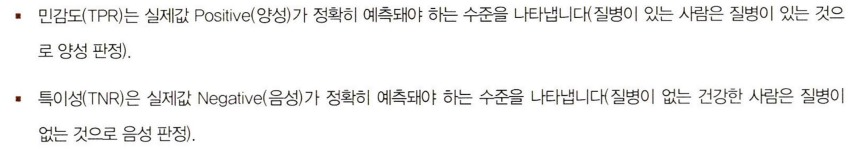

TPR은 재현율. TNR은 특이성.

In [35]:
from sklearn.metrics import roc_curve

#레이블 값이 1일때의 예측 확률을 추출.
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
thr_index = np.arange(1,thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

#5step 단위로 추출된 임계값에 따른 FPR, TPR값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46 51]
샘플용 10개의 임곗값: [0.97 0.65 0.63 0.56 0.45 0.38 0.31 0.13 0.12 0.11 0.1 ]
샘플 임곗값별 FPR: [0.    0.017 0.034 0.076 0.127 0.186 0.237 0.576 0.619 0.754 0.814]
샘플 임곗값별 TPR: [0.033 0.639 0.705 0.754 0.803 0.852 0.902 0.902 0.951 0.967 1.   ]


FPR의 변화에 따른 TPR의 변화를 ROC곡선으로 시각화


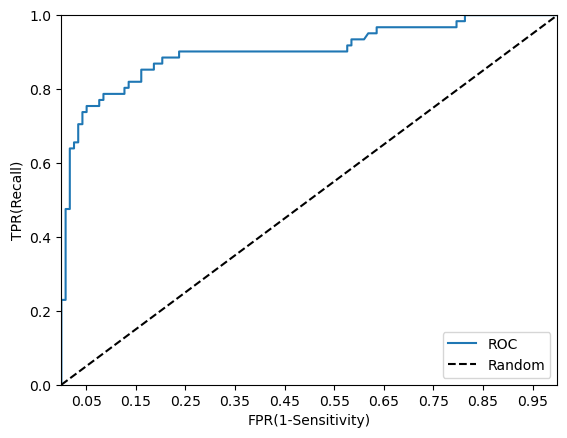

In [36]:
def roc_curve_plot(y_test,pred_proba_c1):
  #임곗값에 따른 FPR,TPR 값을 반환받음.
  fprs,tprs,thresholds = roc_curve(y_test,pred_proba_c1)
  #ROC 곡선을 그래프 곡선으로 그림
  plt.plot(fprs,tprs,label='ROC')
  #가운데 대각선 직선을 그림
  plt.plot([0,1],[0,1],'k--',label='Random')

  #FPR X축의 Scale을 0.1 단위로 변경, X, Y 축 명 설정 등
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start,end,0.1),2))
  plt.xlim(0,1); plt.ylim(0,1)
  plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
  plt.legend()

roc_curve_plot(y_test,pred_proba[:,1])

In [41]:
from sklearn.metrics import roc_auc_score

pred = lr_clf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8341


이제 get_clf_eval()함수는 정확도, 정밀도, 재현율, F1 스코어, ROC AUC값까지 출력 가능.

In [42]:

def get_clf_eval(y_test,pred=None,pred_proba=None):
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  f1 = f1_score(y_test,pred)
  #ROC-AUC 추가
  roc_auc = roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  #ROC-AUC print 추가
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율 : {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision,recall,f1,roc_auc))
     